In [1]:
# ===============================
# Cell 1: Setup and Configuration
# ===============================
%pip install openpyxl
import pandas as pd
import numpy as np
import random
import time
import os
import sys
import subprocess
import re
import ast
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import Workbook
from openpyxl.drawing.image import Image as OpenpyxlImage
from io import BytesIO

# --- CONFIGURATION FOR THE EXPERIMENT ---
BUDGET_PERCENTAGES = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
NUM_RUNS_PER_BUDGET = 30

# --- Define the different GA configurations to be tested ---
GA_CONFIGURATIONS = {
    "V1_Balanced": {
        "max_generations": 500, "crossover_prob": 0.8, "mutation_prob": 0.3
    },
    "V2_Aggressive": {
        "max_generations": 1000, "crossover_prob": 0.95, "mutation_prob": 0.3
    },
    "V3_Deep_Exploration": {
        "max_generations": 1000, "crossover_prob": 0.8, "mutation_prob": 0.3
    },
    "V4_Exhaustive": {
        "max_generations": 2000, "crossover_prob": 1.0, "mutation_prob": 0.3
    }
}

# --- ADDITION: Experiment Selector ---
# --- EDIT THIS LINE to choose which single experiment to run ---
VERSION_TO_RUN = "V2_Aggressive"
# -----------------------------------------------------------

print(f"Selected experiment to run: {VERSION_TO_RUN}")
# Create a new, filtered dictionary containing only the selected version
SINGLE_GA_CONFIGURATION = {VERSION_TO_RUN: GA_CONFIGURATIONS[VERSION_TO_RUN]}

Selected experiment to run: V2_Aggressive


In [2]:
# ======================================================
# Cell 2: The GA Logic as a Reusable Function
# ======================================================

def run_ga_instance(max_exec_time, ga_params, data_maps):

    # Unpack GA parameters and data maps
    max_generations = ga_params['max_generations']
    crossover_prob = ga_params['crossover_prob']
    mutation_prob = ga_params['mutation_prob']

    req_to_tests = data_maps['req_to_tests']
    req_to_bv = data_maps['req_to_bv']
    test_to_time = data_maps['test_to_time']
    all_req_ids = data_maps['all_req_ids']
    bval_to_reqs_map = data_maps['bval_to_reqs_map']
    n_requirements = len(all_req_ids)

    # --- The previous V2 GA logic is preserved here for reference, commented out ---
    #
    # # ----------------------------------------------------------------------
    # # V2 Fitness Function ("Completionist" Version)
    # # ----------------------------------------------------------------------
    # def v2_fitness(chrom):
    #     selected_reqs = {all_req_ids[i] for i, bit in enumerate(chrom) if bit}
    #     if not selected_reqs: return 0
    #     covered_tests = set().union(*(req_to_tests.get(req, set()) for req in selected_reqs))
    #     total_time = sum(test_to_time.get(t, 0) for t in covered_tests)
    #     if total_time > max_exec_time: return 0
    #     fully_covered_bv = 0
    #     for bv_group_value, reqs_in_group in bval_to_reqs_map.items():
    #         if reqs_in_group.issubset(selected_reqs):
    #             fully_covered_bv += bv_group_value
    #     return fully_covered_bv
    #
    # # --- (The rest of the V2 logic would be here) ---


    # ======================================================================
    # NEW V3 GA Logic: Memetic GA with Advanced Operators
    # ======================================================================

    # ----------------------------------------------------------------------
    # Helper: Evaluation Decomposition for Feasibility Rules
    # Sources:
    #   - Deb (2000) "An efficient constraint handling method for genetic algorithms"
    # ----------------------------------------------------------------------
    def evaluate_chrom(chrom):
        covered_tests = set(); total_bv = 0
        for idx, val in enumerate(chrom):
            if val:
                req = all_req_ids[idx]
                covered_tests |= req_to_tests.get(req, set())
                total_bv += req_to_bv.get(req, 0)
        total_time = sum(test_to_time.get(t, 0) for t in covered_tests)
        feasible = (total_time <= max_exec_time)
        violation = max(0, total_time - max_exec_time)
        return total_bv, total_time, feasible, violation

    # ----------------------------------------------------------------------
    # Feasible Initialization (Chu & Beasley, 1998)
    # ----------------------------------------------------------------------
    def feasible_chromosome():
        chrom = [0] * n_requirements; indices = list(range(n_requirements)); random.shuffle(indices)
        covered_tests = set(); total_time = 0
        for idx in indices:
            req = all_req_ids[idx]; tests = req_to_tests.get(req, set())
            new_tests = tests - covered_tests
            additional_time = sum(test_to_time.get(t, 0) for t in new_tests)
            if total_time + additional_time <= max_exec_time:
                chrom[idx] = 1; covered_tests |= new_tests; total_time += additional_time
        return chrom

    population_size = 10
    population = [feasible_chromosome() for _ in range(population_size)]

    # ----------------------------------------------------------------------
    # Greedy Seeding for Budgeted BV Coverage (Khuller, Moss, Naor, 1999)
    # ----------------------------------------------------------------------
    def greedy_seed_variant():
        chrom = [0] * n_requirements; covered = set(); used_time = 0
        remaining = set(range(n_requirements))
        while remaining:
            best_idx, best_score = None, float("-inf")
            for idx in remaining:
                req = all_req_ids[idx]; tests = req_to_tests.get(req, set()); new_tests = tests - covered
                add_time = sum(test_to_time.get(t, 0) for t in new_tests)
                if add_time < 0: continue
                score = req_to_bv.get(req, 0) if add_time == 0 else (req_to_bv.get(req, 0) / (add_time + 1e-12))
                score += random.uniform(-1e-9, 1e-9)
                if used_time + add_time <= max_exec_time and score > best_score:
                    best_idx, best_score = idx, score
            if best_idx is None: break
            req = all_req_ids[best_idx]; new_tests = req_to_tests.get(req, set()) - covered
            add_time = sum(test_to_time.get(t, 0) for t in new_tests)
            if used_time + add_time <= max_exec_time:
                chrom[best_idx] = 1; covered |= new_tests; used_time += add_time
            remaining.remove(best_idx)
        return chrom

    num_seeds = min(3, population_size)
    for i in range(num_seeds): population[i] = greedy_seed_variant()

    # ----------------------------------------------------------------------
    # Value-Aware Repair / Improve Operator
    # ----------------------------------------------------------------------
    def repair_value_aware(chrom):
        chrom = chrom[:]
        # DROP phase
        while True:
            _, _, feasible, _ = evaluate_chrom(chrom)
            if feasible: break
            selected = [i for i, v in enumerate(chrom) if v]
            if not selected: break
            worst_idx, worst_ratio = None, float("inf")
            for idx in selected:
                req = all_req_ids[idx]; covered_other = set()
                for j, v in enumerate(chrom):
                    if v and j != idx: covered_other |= req_to_tests.get(all_req_ids[j], set())
                unique_tests = req_to_tests.get(req, set()) - covered_other
                time_save = sum(test_to_time.get(t, 0) for t in unique_tests)
                bv_loss = req_to_bv.get(req, 0)
                ratio = (bv_loss / (time_save + 1e-12)) if time_save > 0 else float("inf")
                ratio += random.uniform(-1e-9, 1e-9)
                if ratio < worst_ratio: worst_ratio, worst_idx = ratio, idx
            if worst_idx is None: break
            chrom[worst_idx] = 0
        # ADD phase
        while True:
            _, tt, _, _ = evaluate_chrom(chrom); slack = max_exec_time - tt
            if slack <= 0: break
            candidates = [i for i, v in enumerate(chrom) if not v]; best_idx, best_score = None, float("-inf")
            covered_now = set()
            for j, v in enumerate(chrom):
                if v: covered_now |= req_to_tests.get(all_req_ids[j], set())
            for idx in candidates:
                req = all_req_ids[idx]; new_tests = req_to_tests.get(req, set()) - covered_now
                add_time = sum(test_to_time.get(t, 0) for t in new_tests)
                if add_time < 0: continue
                score = req_to_bv.get(req, 0) if add_time == 0 else (req_to_bv.get(req, 0) / (add_time + 1e-12))
                score += random.uniform(-1e-9, 1e-9)
                if add_time <= slack and score > best_score: best_idx, best_score = idx, score
            if best_idx is None: break
            chrom[best_idx] = 1
        return chrom

    # ----------------------------------------------------------------------
    # Fitness Function (Yoo & Harman, 2012, Sec. 5.1)
    # ----------------------------------------------------------------------
    def fitness(chrom):
        total_bv, _, _, _ = evaluate_chrom(chrom)
        return total_bv

    # ----------------------------------------------------------------------
    # Deb-Style Tournament Selection (Deb, 2000)
    # ----------------------------------------------------------------------
    def deb_better(a_eval, b_eval):
        _, _, a_feas, a_viol = a_eval; _, _, b_feas, b_viol = b_eval
        if a_feas and not b_feas: return True
        if b_feas and not a_feas: return False
        if a_feas and b_feas: return a_eval[0] > b_eval[0]
        return a_viol < b_viol
    def deb_tournament_selection(population, k=3):
        contestants = random.sample(population, k=min(k, len(population))); best = contestants[0]
        best_eval = evaluate_chrom(best)
        for c in contestants[1:]:
            c_eval = evaluate_chrom(c)
            if deb_better(c_eval, best_eval): best, best_eval = c, c_eval
        return best

    # ----------------------------------------------------------------------
    # Crossover and Mutation Operators (Mitchell, 1998)
    # ----------------------------------------------------------------------
    def single_point_crossover(parent1, parent2):
        if n_requirements < 2: return parent1[:], parent2[:]
        point = random.randint(1, n_requirements - 1); child1 = parent1[:point] + parent2[point:]; child2 = parent2[:point] + parent1[point:]
        return child1, child2
    def mutate(chromosome, mutation_prob=mutation_prob):
        if random.random() < mutation_prob and n_requirements > 0:
            mutation_idx = random.randint(0, n_requirements - 1); chromosome[mutation_idx] = 1 - chromosome[mutation_idx]

    # ----------------------------------------------------------------------
    # NEW: Hill Climbing Local Search (INSIDE-GA improver)
    # Sources:
    #   - Baseline paper: Section 3.4.3 "Hill Climbing" and Section 3.5 hybridization pattern
    # ----------------------------------------------------------------------
    def hill_climb_improve(chrom):
        current = chrom[:]; improved = True
        while improved:
            improved = False
            best_neighbor, best_neighbor_bv = None, None
            curr_bv, _, _, _ = evaluate_chrom(current)
            for idx in range(n_requirements):
                neighbor = current[:]; neighbor[idx] = 1 - neighbor[idx]
                nb_bv, _, nb_feas, _ = evaluate_chrom(neighbor)
                if nb_feas and nb_bv > curr_bv:
                    if (best_neighbor is None) or (nb_bv > best_neighbor_bv):
                        best_neighbor, best_neighbor_bv = neighbor, nb_bv
            if best_neighbor is not None:
                current = best_neighbor; improved = True
        return current

    # ----------------------------------------------------------------------
    # Main GA Loop (modified to use new operators)
    # ----------------------------------------------------------------------
    for generation in range(max_generations):
        mating_pool = []
        for _ in range(population_size // 2):
            parent1 = deb_tournament_selection(population)
            parent2 = deb_tournament_selection(population)
            mating_pool.append((parent1, parent2))
        offspring = []
        for parent1, parent2 in mating_pool:
            if random.random() < crossover_prob: child1, child2 = single_point_crossover(parent1, parent2)
            else: child1, child2 = parent1[:], parent2[:]
            mutate(child1); mutate(child2)
            child1 = repair_value_aware(child1); child2 = repair_value_aware(child2)
            child1 = hill_climb_improve(child1); child2 = hill_climb_improve(child2)
            offspring.extend([child1, child2])
        combined_population = population + offspring
        def deb_key(ch):
            bv, _, feas, viol = evaluate_chrom(ch); return (0 if feas else 1, viol, -bv)
        combined_population.sort(key=deb_key)
        population = combined_population[:population_size]

    best_solution = population[0]
    best_fitness, _, _, _ = evaluate_chrom(best_solution)
    selected_reqs = [all_req_ids[i] for i, val in enumerate(best_solution) if val]

    return selected_reqs, best_fitness

print("New, advanced GA logic has been refactored into a reusable function.")

New, advanced GA logic has been refactored into a reusable function.


In [3]:
# ===========================================
# Cell 3: Experiment Wrapper & Execution
# ===========================================

def run_single_experiment(version_name, config):
    print("\n--- Starting Experiment: Please upload your mapped_dataset file ---")
    uploaded = files.upload()
    if not uploaded: print("No file selected. Aborting."); return None, None
    input_filename = next(iter(uploaded))

    print(f"Loading data from '{input_filename}'...")
    original_df = pd.read_excel(input_filename)
    TOTAL_EXEC_TIME = original_df.drop_duplicates(subset=['tc_id'])['tc_executiontime'].sum()
    print(f"Total possible execution time from file: {TOTAL_EXEC_TIME:.2f}")

    # Create data maps ONCE
    data_maps = {
        'req_to_tests': original_df.groupby('us_id')['tc_id'].apply(set).to_dict(),
        'req_to_bv': original_df.groupby('us_id')['us_businessvalue'].first().to_dict(),
        'test_to_time': original_df.groupby('tc_id')['tc_executiontime'].first().to_dict(),
        'bval_to_reqs_map': original_df.groupby('us_businessvalue')['us_id'].apply(set).to_dict()
    }
    data_maps['all_req_ids'] = sorted(list(data_maps['req_to_tests'].keys()))

    print("\n" + "="*80 + f"\n--- Running Experiment for Version: {version_name} ---")
    print(f"Parameters: {config}" + "\n" + "="*80)

    # --- ADDITION: Incremental saving logic ---
    output_csv_filename = f"raw_results_{version_name}.csv"
    all_run_data = []

    for budget_pct in BUDGET_PERCENTAGES:
        budget_value = TOTAL_EXEC_TIME * (budget_pct / 100.0)
        print(f"\n--- Running for Budget: {budget_pct}% (Max Time: {budget_value:.2f}) ---")

        for run in range(NUM_RUNS_PER_BUDGET):
            print(f"  Run {run + 1}/{NUM_RUNS_PER_BUDGET}...", end='\r')
            selected_reqs, final_bv = run_ga_instance(budget_value, config, data_maps)
            all_run_data.append({
                'budget_pct': budget_pct, 'run': run + 1,
                'total_business_value': final_bv,
                'num_reqs_covered': len(selected_reqs),
                'selected_reqs': selected_reqs
            })

        # --- Save progress after each budget is fully completed ---
        pd.DataFrame(all_run_data).to_csv(output_csv_filename, index=False)
        print(f"\n  -> Completed {NUM_RUNS_PER_BUDGET} runs. Progress saved to '{output_csv_filename}'.")

    print("\n--- Experiment finished for this version. ---")
    return pd.DataFrame(all_run_data), original_df

# --- This will run ONLY the selected version and save its progress ---
rts_ga_results_df, original_df = run_single_experiment(VERSION_TO_RUN, GA_CONFIGURATIONS[VERSION_TO_RUN])


--- Starting Experiment: Please upload your mapped_dataset file ---


Saving mapped_dataset_1.xlsx to mapped_dataset_1.xlsx
Loading data from 'mapped_dataset_1.xlsx'...
Total possible execution time from file: 349.65

--- Running Experiment for Version: V2_Aggressive ---
Parameters: {'max_generations': 1000, 'crossover_prob': 0.95, 'mutation_prob': 0.3}

--- Running for Budget: 5% (Max Time: 17.48) ---

  -> Completed 30 runs. Progress saved to 'raw_results_V2_Aggressive.csv'.

--- Running for Budget: 10% (Max Time: 34.96) ---

  -> Completed 30 runs. Progress saved to 'raw_results_V2_Aggressive.csv'.

--- Running for Budget: 15% (Max Time: 52.45) ---

  -> Completed 30 runs. Progress saved to 'raw_results_V2_Aggressive.csv'.

--- Running for Budget: 20% (Max Time: 69.93) ---

  -> Completed 30 runs. Progress saved to 'raw_results_V2_Aggressive.csv'.

--- Running for Budget: 25% (Max Time: 87.41) ---

  -> Completed 30 runs. Progress saved to 'raw_results_V2_Aggressive.csv'.

--- Running for Budget: 30% (Max Time: 104.89) ---

  -> Completed 30 runs. Pro



--- Starting Final Analysis and Reporting ---
Please upload the 'BCPSO_Statistical_Analysis_Report.xlsx' file for comparison.


Saving BCPSO_Statistical_Analysis_Report.xlsx to BCPSO_Statistical_Analysis_Report.xlsx
BCPSO summary data loaded successfully.

------------------------------------------------------------
Processing: V2_Aggressive
------------------------------------------------------------

--- V2_Aggressive Final Summary Table ---
    budget_pct   mean_reqs  median_reqs      mean_bv  median_bv  Req Coverage %
0            5   26.533333         26.0   715.866667      711.0       21.397849
1           10   44.300000         44.0  1099.533333     1098.0       35.725806
2           15   63.133333         63.0  1430.933333     1429.0       50.913978
3           20   75.000000         75.0  1659.000000     1659.0       60.483871
4           25   85.000000         85.0  1785.000000     1785.0       68.548387
5           30   95.000000         95.0  1853.000000     1853.0       76.612903
6           35   95.000000         95.0  1853.000000     1853.0       76.612903
7           40   94.366667         95.0 

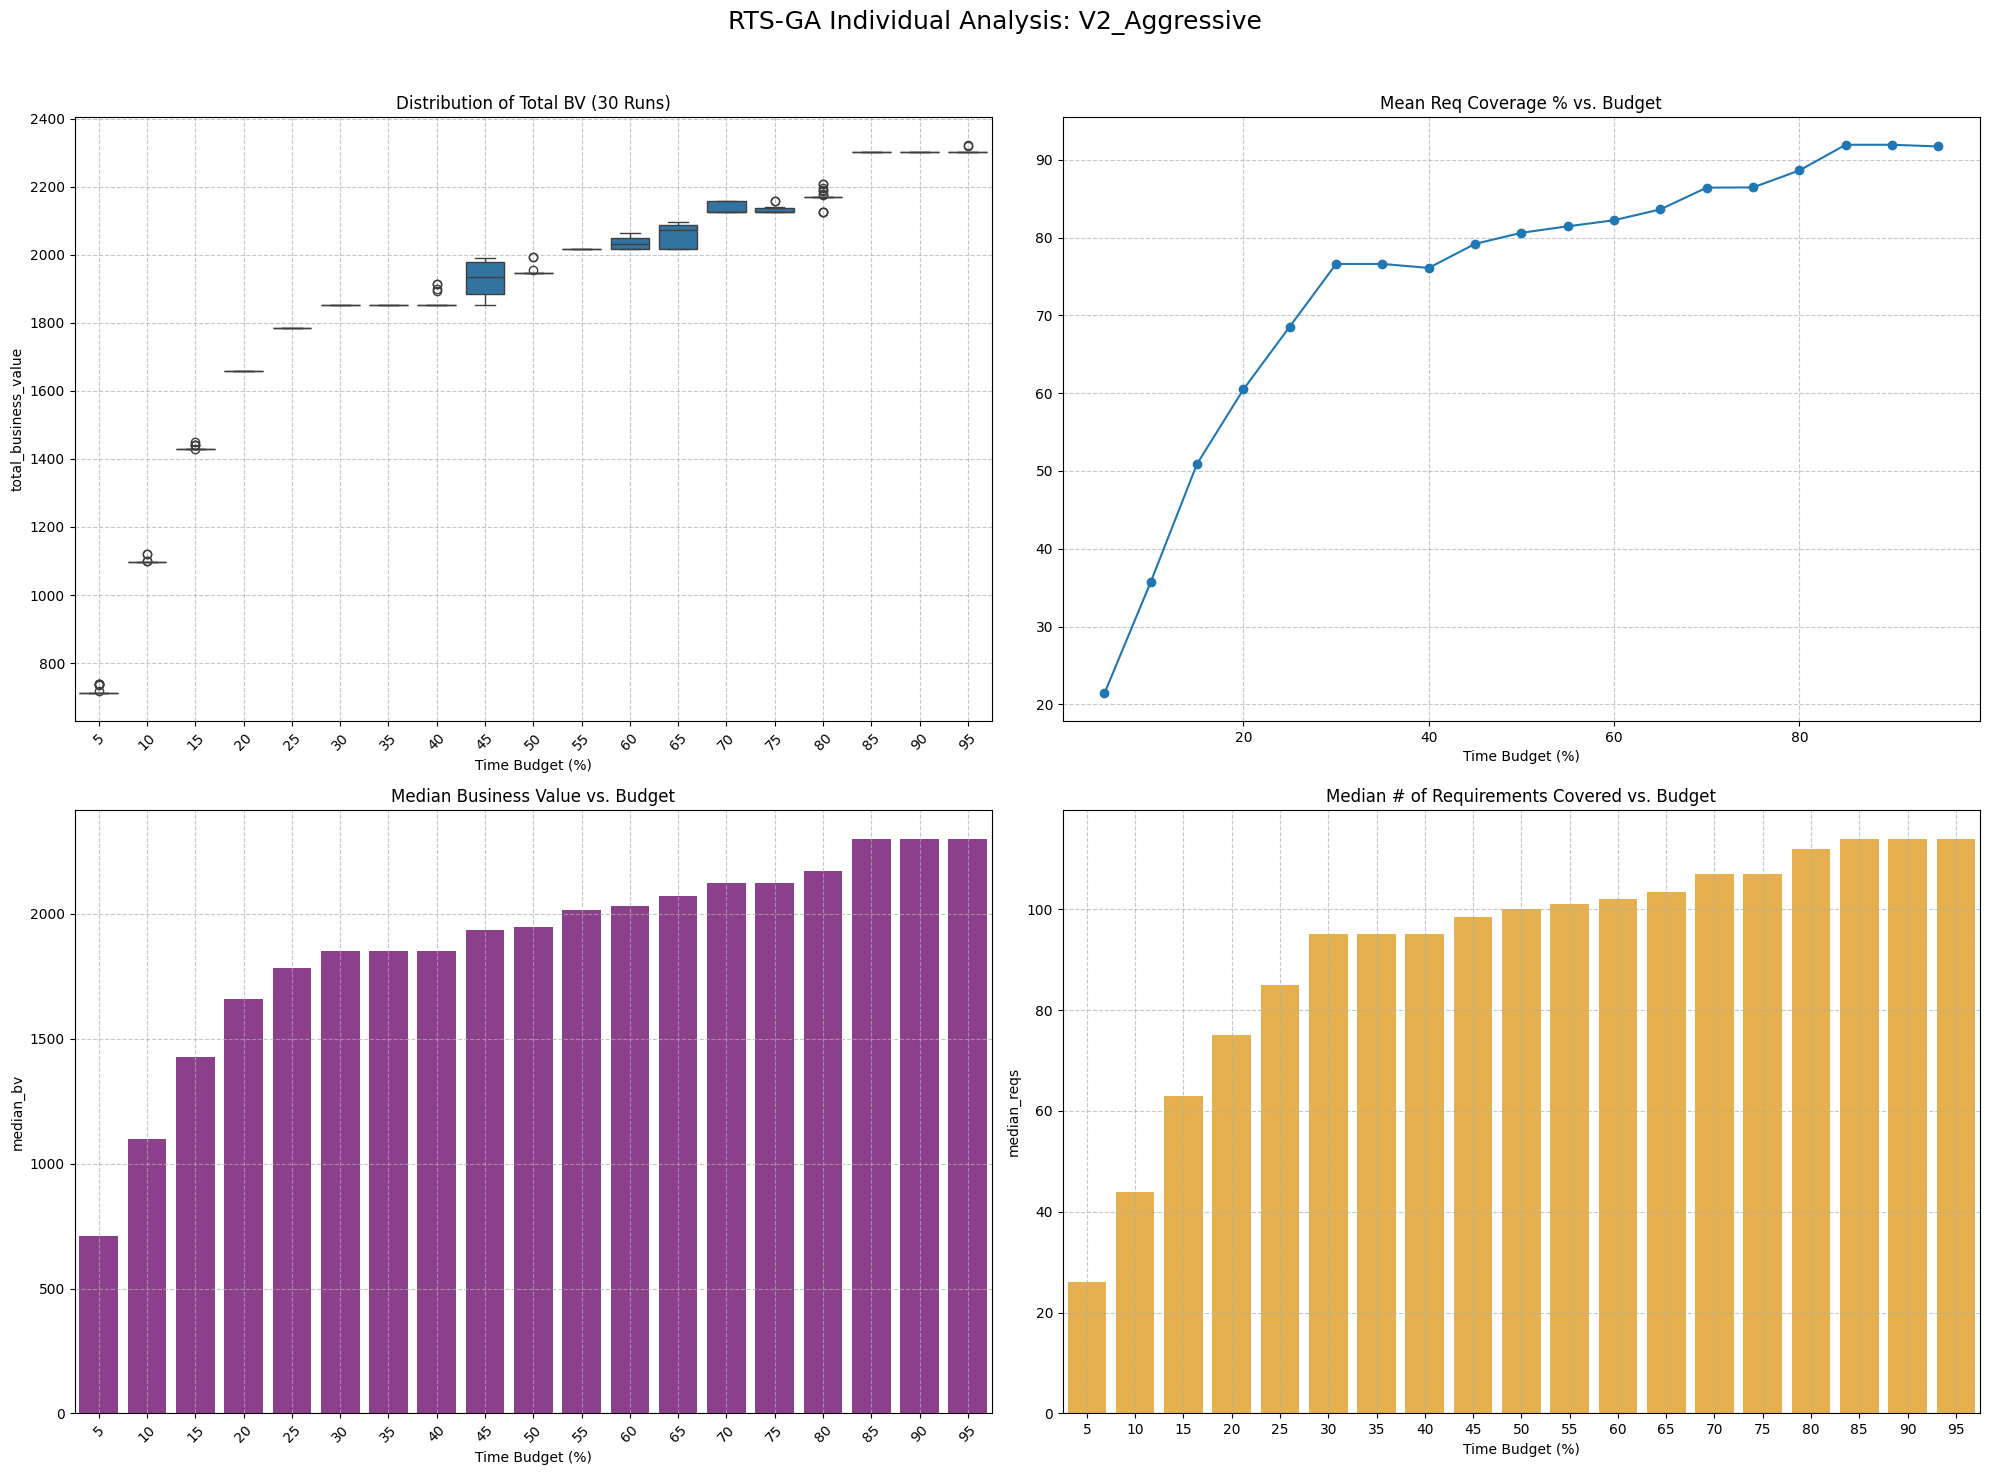

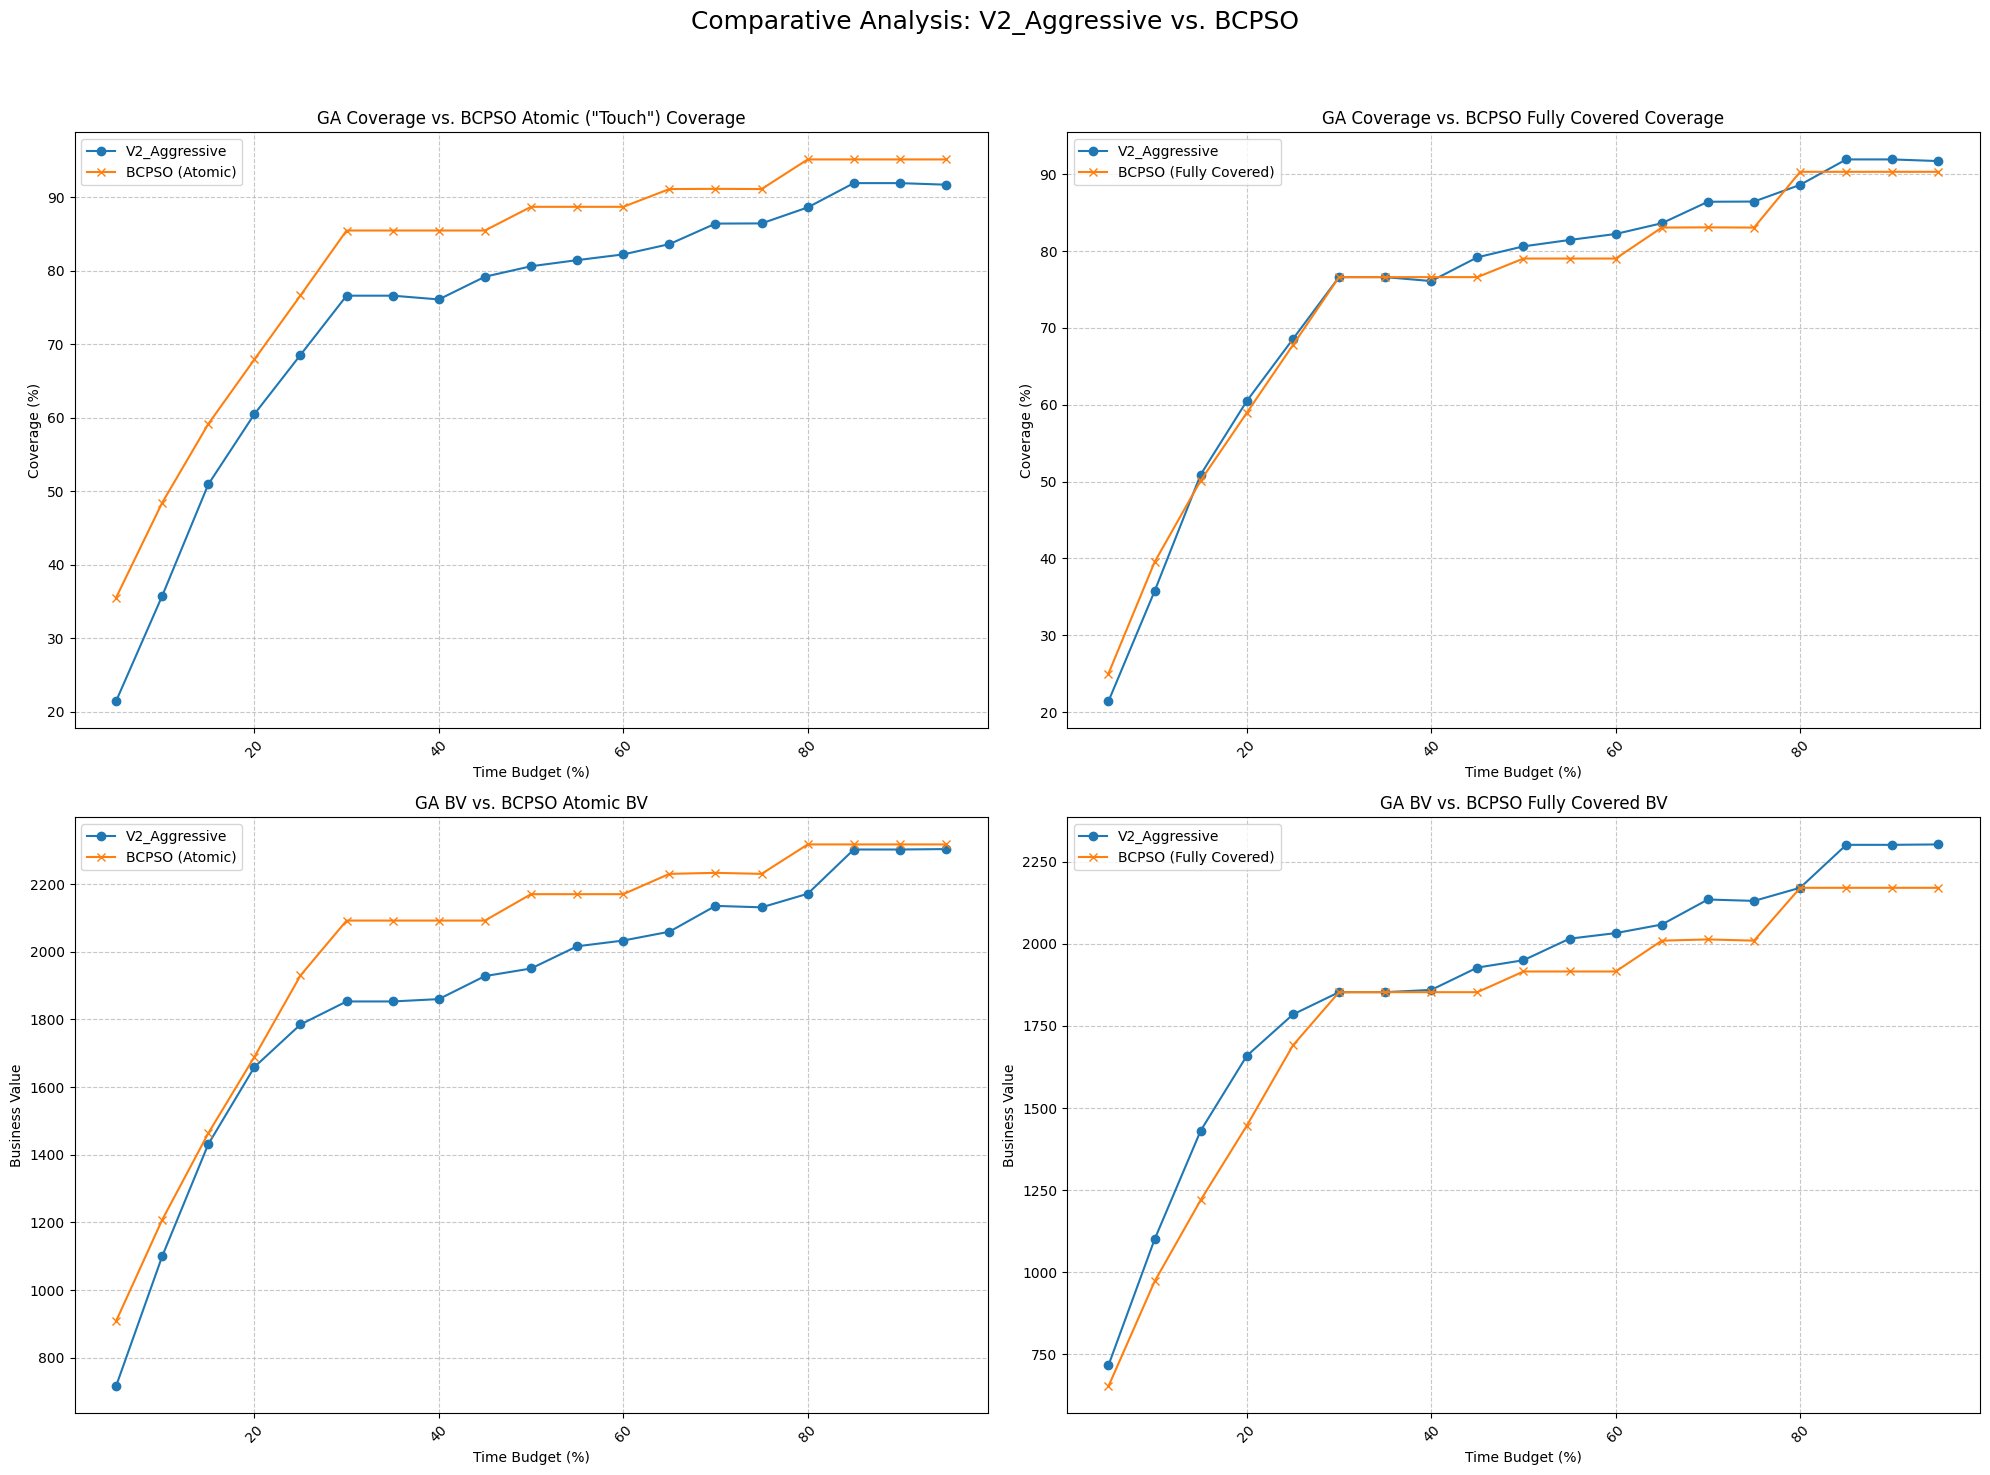


Generating report: 'Comprehensive_Report_V2_Aggressive.xlsx'
Report for V2_Aggressive saved.


In [4]:
# ========================================================
# Cell 4: Statistical Analysis and Final Report
# ========================================================

if 'rts_ga_results_df' in locals() and rts_ga_results_df is not None:
    print("\n\n" + "="*60 + "\n--- Starting Final Analysis and Reporting ---")
    print("Please upload the 'BCPSO_Statistical_Analysis_Report.xlsx' file for comparison.")
    uploaded_bcpso = files.upload()

    if uploaded_bcpso:
        bcpso_filename = next(iter(uploaded_bcpso))
        bcpso_summary_df = pd.read_excel(bcpso_filename, sheet_name='BCPSO Summary Table')
        print("BCPSO summary data loaded successfully.")

        version_name = VERSION_TO_RUN
        results_df = rts_ga_results_df

        print("\n" + "-"*60 + f"\nProcessing: {version_name}\n" + "-"*60)

        summary_stats_ga = results_df.groupby('budget_pct').agg(
            mean_reqs=('num_reqs_covered', 'mean'), median_reqs=('num_reqs_covered', 'median'),
            mean_bv=('total_business_value', 'mean'), median_bv=('total_business_value', 'median')
        ).reset_index()
        num_total_reqs = original_df['us_id'].nunique()
        summary_stats_ga['Req Coverage %'] = (summary_stats_ga['mean_reqs'] / num_total_reqs) * 100

        print(f"\n--- {version_name} Final Summary Table ---"); print(summary_stats_ga.to_string())

        # Individual GA Plots
        fig_indiv, axes_indiv = plt.subplots(2, 2, figsize=(20, 15))
        fig_indiv.suptitle(f'RTS-GA Individual Analysis: {version_name}', fontsize=18)
        sns.boxplot(ax=axes_indiv[0, 0], x='budget_pct', y='total_business_value', data=results_df); axes_indiv[0, 0].set_title('Distribution of Total BV (30 Runs)'); axes_indiv[0, 0].tick_params(axis='x', rotation=45)
        axes_indiv[0, 1].plot(summary_stats_ga['budget_pct'], summary_stats_ga['Req Coverage %'], marker='o'); axes_indiv[0, 1].set_title('Mean Req Coverage % vs. Budget')
        sns.barplot(ax=axes_indiv[1, 0], x='budget_pct', y='median_bv', data=summary_stats_ga, color='purple', alpha=0.8); axes_indiv[1, 0].set_title('Median Business Value vs. Budget'); axes_indiv[1, 0].tick_params(axis='x', rotation=45)
        sns.barplot(ax=axes_indiv[1, 1], x='budget_pct', y='median_reqs', data=summary_stats_ga, color='orange', alpha=0.8); axes_indiv[1, 1].set_title('Median # of Requirements Covered vs. Budget')
        for ax in axes_indiv.flat: ax.set_xlabel('Time Budget (%)'); ax.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

        # Comparative Plots
        fig_comp, axes_comp = plt.subplots(2, 2, figsize=(20, 15))
        fig_comp.suptitle(f'Comparative Analysis: {version_name} vs. BCPSO', fontsize=18)
        axes_comp[0, 0].plot(summary_stats_ga['budget_pct'], summary_stats_ga['Req Coverage %'], marker='o', label=f'{version_name}'); axes_comp[0, 0].plot(bcpso_summary_df['Time Budget %'], bcpso_summary_df['mean_atomic_req_cov'], marker='x', label='BCPSO (Atomic)'); axes_comp[0, 0].set_title('GA Coverage vs. BCPSO Atomic ("Touch") Coverage'); axes_comp[0, 0].legend(); axes_comp[0, 0].set_ylabel('Coverage (%)')
        axes_comp[0, 1].plot(summary_stats_ga['budget_pct'], summary_stats_ga['Req Coverage %'], marker='o', label=f'{version_name}'); axes_comp[0, 1].plot(bcpso_summary_df['Time Budget %'], bcpso_summary_df['mean_fully_covered_req_cov'], marker='x', label='BCPSO (Fully Covered)'); axes_comp[0, 1].set_title('GA Coverage vs. BCPSO Fully Covered Coverage'); axes_comp[0, 1].legend(); axes_comp[0, 1].set_ylabel('Coverage (%)')
        axes_comp[1, 0].plot(summary_stats_ga['budget_pct'], summary_stats_ga['mean_bv'], marker='o', label=f'{version_name}'); axes_comp[1, 0].plot(bcpso_summary_df['Time Budget %'], bcpso_summary_df['mean_atomic_bv'], marker='x', label='BCPSO (Atomic)'); axes_comp[1, 0].set_title('GA BV vs. BCPSO Atomic BV'); axes_comp[1, 0].legend(); axes_comp[1, 0].set_ylabel('Business Value')
        axes_comp[1, 1].plot(summary_stats_ga['budget_pct'], summary_stats_ga['mean_bv'], marker='o', label=f'{version_name}'); axes_comp[1, 1].plot(bcpso_summary_df['Time Budget %'], bcpso_summary_df['mean_fully_covered_bv'], marker='x', label='BCPSO (Fully Covered)'); axes_comp[1, 1].set_title('GA BV vs. BCPSO Fully Covered BV'); axes_comp[1, 1].legend(); axes_comp[1, 1].set_ylabel('Business Value')
        for ax in axes_comp.flat: ax.set_xlabel('Time Budget (%)'); ax.grid(True, linestyle='--', alpha=0.7); ax.tick_params(axis='x', rotation=45)
        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

        output_excel_filename = f"Comprehensive_Report_{version_name}.xlsx"
        print(f"\nGenerating report: '{output_excel_filename}'")
        img_buffer_indiv = BytesIO(); fig_indiv.savefig(img_buffer_indiv, format='png'); img_buffer_indiv.seek(0)
        img_buffer_comp = BytesIO(); fig_comp.savefig(img_buffer_comp, format='png'); img_buffer_comp.seek(0)
        with pd.ExcelWriter(output_excel_filename, engine='openpyxl') as writer:
            results_df.to_excel(writer, sheet_name='RTS-GA Raw Runs', index=False); summary_stats_ga.to_excel(writer, sheet_name='RTS-GA Summary', index=False)
            bcpso_summary_df.to_excel(writer, sheet_name='BCPSO Summary', index=False); ws = writer.book.create_sheet(title="Analysis Plots")
            ws.add_image(OpenpyxlImage(img_buffer_indiv), 'A1'); ws.add_image(OpenpyxlImage(img_buffer_comp), 'A80')
        print(f"Report for {version_name} saved.")
    else: print("\nBCPSO file not uploaded.")
else: print("\nNo RTS-GA data collected.")